In [ ]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy 
from scipy.integrate import quad
from scipy.misc import derivative

In [ ]:
# Цена доставки материалов
alpha = 0.1

# Функция поверхности
def beta(x, y):
    return 1 + np.sin(5*x) * np.sin(y)

# Параметры агентов
num_of_agents = 250
message_distance = 0.5
step = 0.1
num_of_iter = 25

In [ ]:
# Класс агента
class Bat:
    def __init__(self, loc_x0, loc_y0, loc_x1, loc_y1, destiny, success): 
        self.loc_x0 = loc_x0 # координаты x старые
        self.loc_y0 = loc_y0 # координаты y старые
        self.loc_x1 = loc_x1 # координаты x новые
        self.loc_y1 = loc_y1 # координаты y новые
        self.destiny = destiny # 0 - идет в А, 1 - идет в В
        self.success = success # 0 - не находил точку, 1 - находил

In [ ]:
def dist(x1, y1, x2, y2):
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [ ]:
def ifoc(x1, y1, x2, y2): 
  if x2 < x1: 
    x1, x2 = x2, x1
    y1, y2 = y2, y1
  len = dist(x1, y1, x2, y2) 
  if x2 - x1 != 0:
     k = (y2 - y1) / (x2 - x1) 
  else: 
    k = 0 
  x_range = np.linspace(x1, x2, 11).tolist() 
  y_range = [k * x + y1 - k * x1 for x in x_range] 
  sum = 0 
  for i in range(10): 
    sum += beta((x_range[i] + x_range[i + 1]) / 2, (y_range[i] + y_range[i + 1]) / 2) 
  return (alpha / 2) * len**2 + (len / 10) * sum

In [ ]:
# Функция для случайного распределения агентов по узлам сетки
def one_dim_batset(num):
  coords = np.random.rand(num, 1).tolist()
  flatList = sum(coords, [])
  res = np.array(flatList)
  return res
  
bats_x, bats_y = one_dim_batset(num_of_agents), one_dim_batset(num_of_agents)

In [ ]:
# Создание массива мышей
def bat_init():
  lst = []
  for i in range(num_of_agents):
    stuff = rnd.choice([0, 1])
    agent = Bat(bats_x.tolist()[i], bats_y.tolist()[i], stuff, stuff, rnd.choice([0, 1]), 0)
    lst.append(agent)
  return lst

bats = bat_init()

In [ ]:
# Функция для перемещения агента
def move(x1, y1, x2, y2, pos):
  x_new = x1 + step * (x2 - x1) / dist(x1, y1, x2, y2)
  y_new = y1 + step * (y2 - y1) / dist(x1, y1, x2, y2)
  if x_new < 0:
    x_new = 0
    bats[pos].destiny = 1
  if x_new > 1:
    x_new = 1
    bats[pos].destiny = 0
  if y_new < 0:
    y_new = 0
    bats[pos].destiny = 1
  if y_new > 1:
    y_new = 1
    bats[pos].destiny = 0
  bats[pos].loc_x0 = x_new
  bats[pos].loc_y0 = y_new


In [ ]:
# Отрисовка поверхности 
def drawing_the_result(agents_x, agents_y, iter):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  fig, ax = plt.subplots()
  fig.set_figwidth(3)    
  fig.set_figheight(3)    
  ax = fig.add_subplot()
  ax.set_title(f"Итерация № {iter + 1}")
  ax.grid()
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(-0.1, 1.9, 1000), cmap="gray")
  ax.scatter(agents_x, agents_y, marker=".", color='blue')
  plt.minorticks_on()
  plt.grid(which='major', linestyle='-')
  plt.grid(which='minor', linestyle='-')
  axins = inset_axes(ax,
                   width="7%",
                   height="100%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()

In [ ]:
def bat_algo():
  # если цель - 0 - сравнивают с расстоянием до 1, иначе до 0
  # не улетаем сразу, а сначала слушаем крики и выбираем, потом, когда все послушали, летим

  # фаза выбора цели для тех, кто ещё не доходил до какого-либо пункта
  for i in range(num_of_agents):
    if bats[i].success == 0:
      bats[i].destiny = rnd.choice([0, 1])

  for i in range(num_of_agents):
    stuff1 = rnd.choice([0, 1])
    stuff2 = stuff1
    bats[i].loc_x1, bats[i].loc_y1 = stuff1, stuff2

  # фаза поиска новой точки 
  for i in range(num_of_agents):    
    next_place_x, next_place_y = 1.01, 1.01
    best_fun = ifoc(0, 0, bats[i].loc_x0, bats[i].loc_y0) + ifoc(bats[i].loc_x0, bats[i].loc_y0, 1, 1)
    for k in range(num_of_agents):
      if k != i and dist(bats[i].loc_x0, bats[i].loc_y0, bats[k].loc_x0, bats[k].loc_y0) <= message_distance:
        if bats[i].destiny == 0:
          next_ifoc = ifoc(bats[i].loc_x0, bats[i].loc_y0, 1, 1) + ifoc(bats[k].loc_x0, bats[k].loc_y0, bats[i].loc_x0, bats[i].loc_y0)\
                       + ifoc(bats[k].loc_x0, bats[k].loc_y0, 0, 0)
        else:
          next_ifoc = ifoc(bats[i].loc_x0, bats[i].loc_y0, 0, 0) + ifoc(bats[k].loc_x0, bats[k].loc_y0, bats[i].loc_x0, bats[i].loc_y0)\
                       + ifoc(bats[k].loc_x0, bats[k].loc_y0, 1, 1)
        if next_ifoc < best_fun:
          best_fun = next_ifoc
          next_place_x, next_place_y = bats[k].loc_x0, bats[k].loc_y0

    # выбор следующей точки
    if next_place_x == 1.01 and next_place_y == 1.01:
      if bats[i].destiny == 0:
          bats[i].loc_x1, bats[i].loc_y1 = 0, 0
      else:
          bats[i].loc_x1, bats[i].loc_y1 = 1, 1
    else:
          bats[i].loc_x1, bats[i].loc_y1 = next_place_x, next_place_y
    
    
  # перелет в направлении выбранной точки
  for i in range(num_of_agents):
    move(bats[i].loc_x0, bats[i].loc_y0, bats[i].loc_x1, bats[i].loc_y1, i)

  # фаза записи перелётов 
  for i in range(num_of_agents):
    #bats[i].loc_x0 = bats[i].loc_x1   
    bats_x[i] = bats[i].loc_x0 
    #bats[i].loc_y0 = bats[i].loc_y1   
    bats_y[i] = bats[i].loc_y0   

   # фаза поощрений за успех  
  for i in range(num_of_agents):
    if bats[i].loc_x0 == bats[i].loc_y0 == 0:
      bats[i].success = 1
      bats[i].destiny = 1
    elif bats[i].loc_x0 == bats[i].loc_y0 == 1:
      bats[i].success = 1
      bats[i].destiny = 0

  return bats_x, bats_y

<ipython-input-9-18deaee83483>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


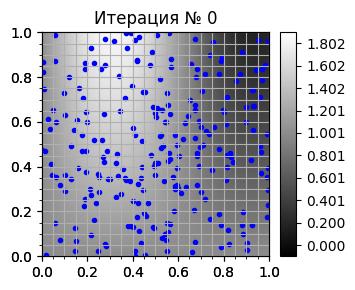

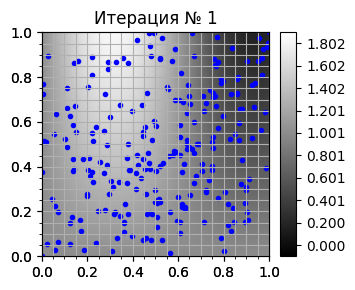

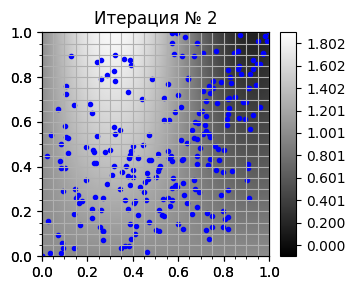

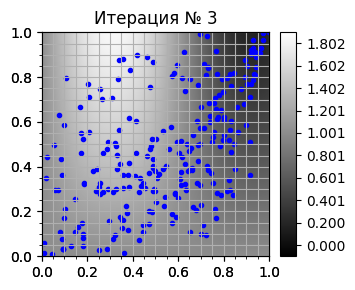

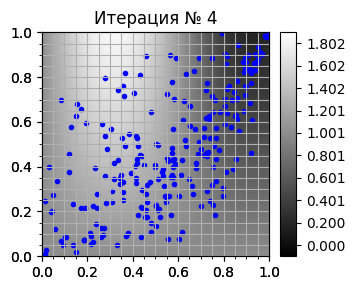

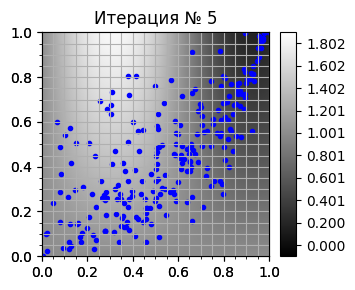

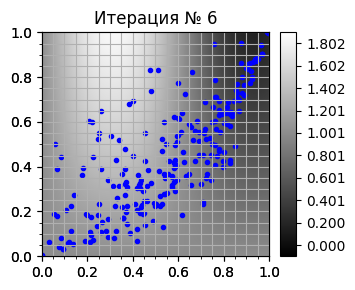

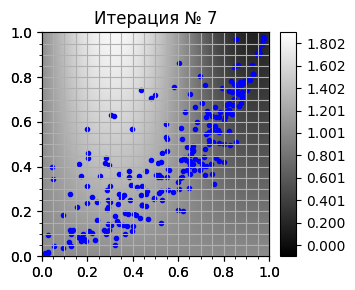

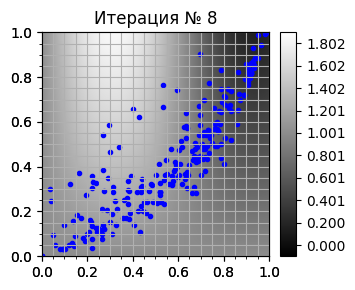

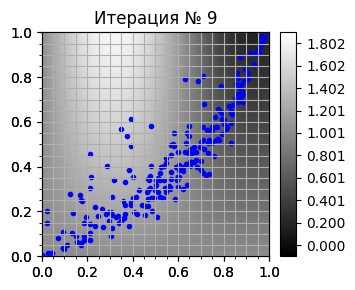

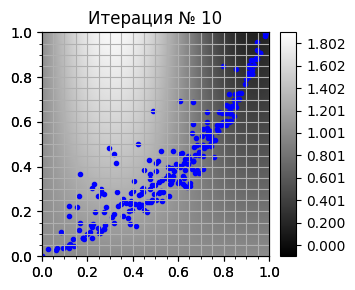

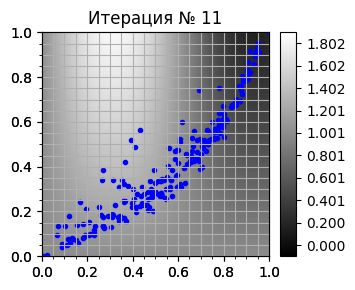

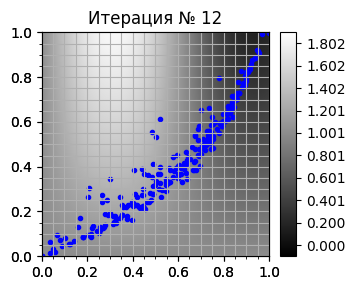

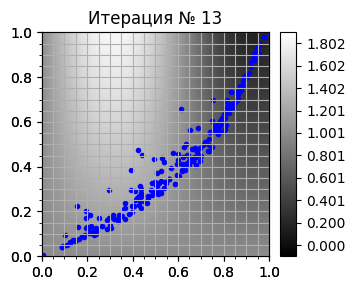

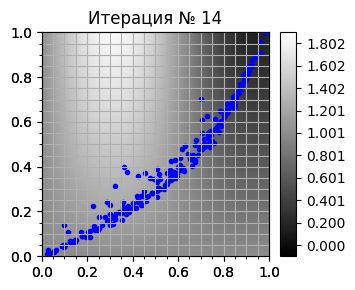

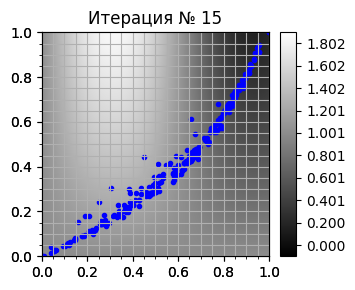

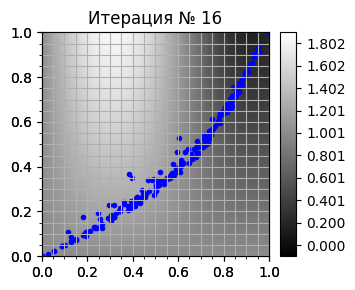

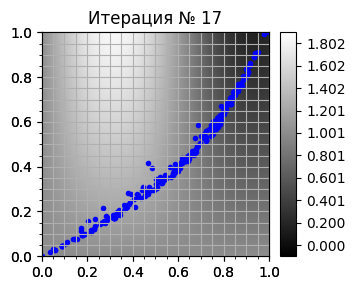

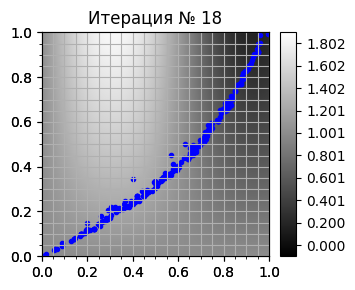

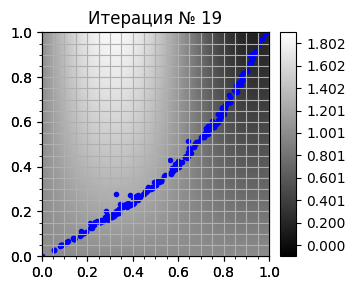

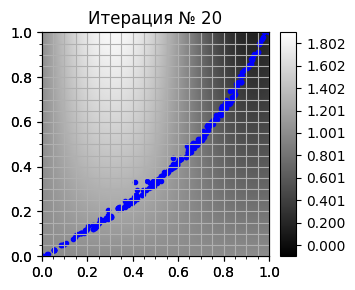

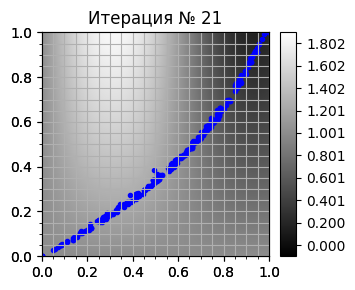

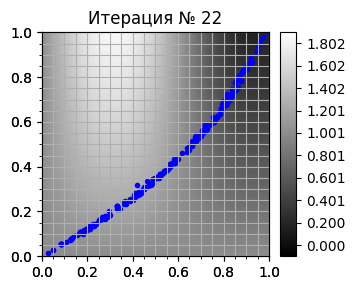

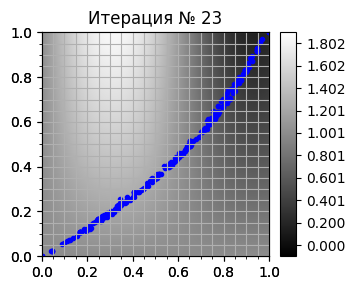

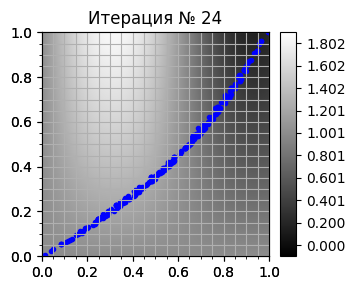

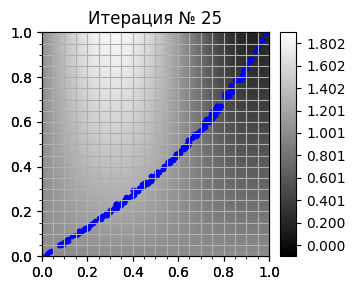

In [ ]:
drawing_the_result(bats_x, bats_y, -1)
for i in range(num_of_iter):
  cur_loc_x, cur_loc_y = bat_algo()
  drawing_the_result(cur_loc_x, cur_loc_y, i)


In [ ]:
nodes = []
interp_nodes = []
for i in range(num_of_agents):
  nodes.append((float('{:.5f}'.format(cur_loc_x[i])), float('{:.5f}'.format(cur_loc_y[i]))))
sorted_nodes = sorted(nodes)

q = round(num_of_agents*0.09)
interp_nodes = []
for i in range(0, num_of_agents, round(num_of_agents / q)):
  interp_nodes.append(sorted_nodes[i])
interp_nodes.append((1, 1))

interp_x = []
interp_y = []
for item in interp_nodes:
  interp_x.append(item[0])
  interp_y.append(item[1])
print(interp_nodes)
print(interp_x)
print(interp_y)

[(0.0, 0.0), (0.09073, 0.05334), (0.16576, 0.11186), (0.2058, 0.12694), (0.28507, 0.18227), (0.32545, 0.23168), (0.36201, 0.24318), (0.40321, 0.29442), (0.44517, 0.30925), (0.48061, 0.35678), (0.50845, 0.37503), (0.56485, 0.42399), (0.58992, 0.45874), (0.62463, 0.48663), (0.64412, 0.49877), (0.69687, 0.56049), (0.71682, 0.58763), (0.74402, 0.63606), (0.76781, 0.64316), (0.8106, 0.72486), (0.83746, 0.74347), (0.88869, 0.83392), (0.94514, 0.91639), (1, 1)]
[0.0, 0.09073, 0.16576, 0.2058, 0.28507, 0.32545, 0.36201, 0.40321, 0.44517, 0.48061, 0.50845, 0.56485, 0.58992, 0.62463, 0.64412, 0.69687, 0.71682, 0.74402, 0.76781, 0.8106, 0.83746, 0.88869, 0.94514, 1]
[0.0, 0.05334, 0.11186, 0.12694, 0.18227, 0.23168, 0.24318, 0.29442, 0.30925, 0.35678, 0.37503, 0.42399, 0.45874, 0.48663, 0.49877, 0.56049, 0.58763, 0.63606, 0.64316, 0.72486, 0.74347, 0.83392, 0.91639, 1]


In [ ]:
# Метод неопределённых коэффициентов
x = Symbol('x', real=True)
right_part = np.array(interp_y)
matrix = []
for i in range(len(interp_x)):
  line = []
  for j in range(len(interp_x)):
    line.append(float('{:.5f}'.format(interp_x[i]**j)))
  matrix.append(line)
coeff = np.linalg.solve(np.array(matrix), right_part).tolist()
equation = 0
for i in range(len(interp_x)):
  equation += float('{:.4f}'.format(coeff[i]))*x**i
print(equation)

-3359.8158*x**23 + 2804.6368*x**22 + 9434.412*x**21 - 8630.9424*x**20 - 2781.3431*x**19 - 3416.6879*x**18 + 6377.8948*x**17 + 432.4819*x**16 + 1099.4457*x**15 - 23.4482*x**14 - 3728.7474*x**13 + 1405.5147*x**12 + 479.428*x**11 + 1328.5947*x**10 - 3575.9978*x**9 + 2862.8414*x**8 - 594.1697*x**7 + 283.291*x**6 - 885.1382*x**5 + 669.4801*x**4 - 208.4992*x**3 + 28.4577*x**2 - 0.6889*x


<ipython-input-14-2b009ddd7378>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


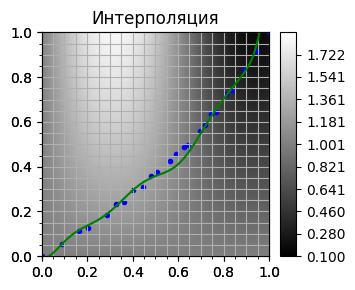

In [ ]:
def drawing_the_line(func):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  xg = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  fig.set_figwidth(3)    
  fig.set_figheight(3)    
  ax = fig.add_subplot()
  ax.set_title(f"Интерполяция")
  ax.grid()
  plt.axis([0, 1, 0, 1])
  plt.grid(which='major', linestyle='-')
  plt.grid(which='minor', linestyle='-')
  plt.minorticks_on()
    
  yg = [func.subs(x, i) for i in xg]
  plt.plot(xg, yg, 'g-')
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(0.1, 1.9, 1000), cmap="gray")
  ax.scatter(interp_x, interp_y, marker=".", color='blue')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()

drawing_the_line(equation)

In [ ]:
def sqrt_part(x): #sqrt(1+y'**2)
  return sqrt(1 + (equation.diff(x))**2)

def beta_mul_sqrt(x):
  return sqrt_part(x)*beta(x, y(x)) #beta(x, y)*sqrt(1+y'**2)

print(alpha/2*(quad(sqrt_part,0 , 1)[0])**2 \
+ quad(beta_mul_sqrt, 0 , 1)[0])

ValueError: ignored